In [2]:
# 引入库
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# 导入数据集
transform = transforms.Compose([
    transforms.ToTensor(),#将图像转换为张量
    transforms.Normalize((0.5, ), (0.5, )) #数据归一化
])

dataset = datasets.CIFAR10(root='./data/', train=True, transform=transform, download=True)


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data/


这里代码中的(0.5, )和(0.5, )适用于灰度图像，因为灰度图只有一个通道。而如果将其改为((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))，则表示每个通道（红色、绿色和蓝色通道）都采用均值0.5和标准差0.5，这通常用于三通道的彩色图像。
这里使用一个通道的原因可能在于减少计算量，对于图像数据颜色的重要度不高

In [3]:
# 导入库
from torch.utils.data import random_split

# 设置学生ID的最后一位数字
student_last_id = 5
split_ratio = 0.7 if student_last_id <= 4 else 0.8

# 根据ID拆分数据集，8:2
train_size=int(len(dataset)*split_ratio)
val_size=len(dataset)-train_size
train_dataset,val_dataset=random_split(dataset,[train_size,val_size])

# 数据加载器
from torch.utils.data import DataLoader
batch_size=32+student_last_id
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
print(f"training on {train_size} images, validation on {val_size} images")


training on 40000 images, validation on 10000 images


In [8]:
# 将学习率设为0.001+ID*0.0001，训练轮次10+ID
# 导入库
import torch
import torch.optim as optim

# 定义神经网络模型
model = torch.nn.Sequential(
    torch.nn.Flatten(),  # 输入层：将 32x32x3 的图像展平为 3072 维向量
    torch.nn.Linear(32 * 32 * 3, 512),  # 全连接层：输入 3072 维，输出 512 维
    torch.nn.BatchNorm1d(512),  # 批标准化：加快训练并提高模型的泛化能力
    torch.nn.ReLU(),  # 激活函数：ReLU 激活函数引入非线性
    torch.nn.Linear(512, 256),  # 增加隐藏层：输入 512 维，输出 256 维
    torch.nn.BatchNorm1d(256),  # 批标准化：再次增强模型的稳定性和收敛速度
    torch.nn.ReLU(),  # 激活函数：隐藏层的 ReLU 激活
    torch.nn.Linear(256, 10),  # 输出层：将隐藏层输出映射到 10 类
)

# 损失函数
criterion = torch.nn.CrossEntropyLoss()

# 学习率设置
lr = 0.001 + (student_last_id * 0.0001)

# Adam 优化器
optimizer = optim.Adam(model.parameters(), lr=lr)

# 训练轮次
epochs = 10 + student_last_id

print(f"Training for {epochs} epochs with learning rate {lr}")

Training for 15 epochs with learning rate 0.0015


In [9]:
# 模型训练和评估，并跟踪损失和准确性
train_losses=[]
train_accuracies=[]
val_accuracies=[]

for epoch in range(epochs):
    model.train()
    running_loss=0.0
    corrects=0
    total=0
    for inputs,labels in train_loader:
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        _,preds=torch.max(outputs,1)
        total+=labels.size(0)
        corrects+=(preds==labels).sum().item()
    
    train_accuracy=100*corrects/total
    print(f'epoch:{epoch+1}/{epochs},loss:{running_loss:.4f},accuracy:{train_accuracy:.2f}%')

    # 评估模型
    model.eval()
    corrects=0
    total=0
    with torch.no_grad():
        for inputs,labels in val_loader:
            outputs=model(inputs)
            _,preds=torch.max(outputs,1)
            total+=labels.size(0)
            corrects+=(preds==labels).sum().item()

    val_accuracy=100*corrects/total
    print(f'Validation Accuracy:{val_accuracy:.2f}%')

    train_losses.append(running_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)


epoch:1/15,loss:1798.2173,accuracy:40.62%
Validation Accuracy:46.80%
epoch:2/15,loss:1577.9432,accuracy:47.80%
Validation Accuracy:50.78%
epoch:3/15,loss:1474.9624,accuracy:51.29%
Validation Accuracy:51.60%
epoch:4/15,loss:1379.4320,accuracy:54.45%
Validation Accuracy:52.86%
epoch:5/15,loss:1303.2181,accuracy:57.03%
Validation Accuracy:53.75%
epoch:6/15,loss:1228.6561,accuracy:59.23%
Validation Accuracy:53.50%
epoch:7/15,loss:1163.6184,accuracy:61.66%
Validation Accuracy:54.63%
epoch:8/15,loss:1094.6094,accuracy:64.17%
Validation Accuracy:54.69%
epoch:9/15,loss:1044.0567,accuracy:65.74%
Validation Accuracy:54.88%
epoch:10/15,loss:975.7053,accuracy:68.14%
Validation Accuracy:55.72%
epoch:11/15,loss:914.6387,accuracy:70.01%
Validation Accuracy:55.62%
epoch:12/15,loss:859.3885,accuracy:71.67%
Validation Accuracy:55.62%
epoch:13/15,loss:803.2874,accuracy:73.69%
Validation Accuracy:55.41%
epoch:14/15,loss:754.5844,accuracy:75.25%
Validation Accuracy:55.19%
epoch:15/15,loss:706.3056,accuracy

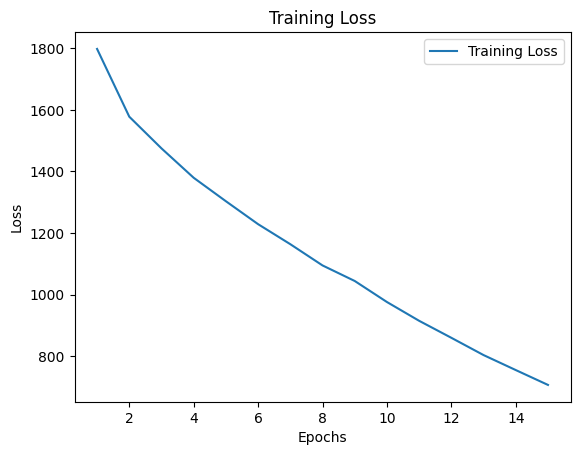

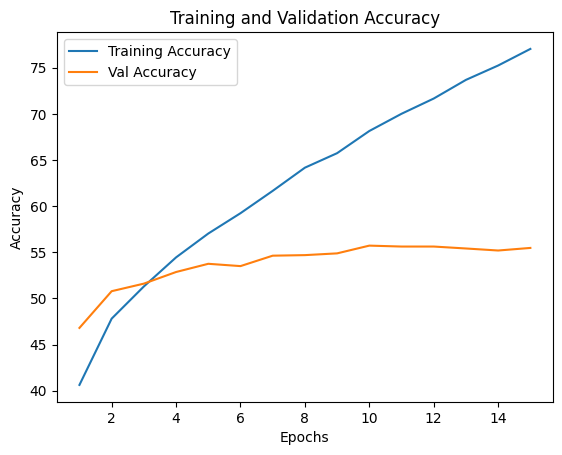

In [10]:
# 可视化和分析结果
import matplotlib.pyplot as plt

# 绘制损失
plt.figure()
plt.plot(range(1,epochs+1),train_losses,label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# 绘制准确率
plt.figure()
plt.plot(range(1,epochs+1),train_accuracies,label='Training Accuracy')
plt.plot(range(1,epochs+1),val_accuracies,label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## 简要报告：
### 1.个性化设置
QMid尾号5，所以数据集拆分成8：2，epoch为15，rl为0.0015，batch_size为37
### 2.神经网络架构与训练
在模型的架构上，我对案例的模型进行了一些调整，在训练效果上的提升很明显。  
**输入层**：  
torch.nn.Flatten() 将 32x32x3 的图像展平为 3072 维的向量，以便能够输入到后续的全连接层。  

**隐藏层**：  
首层 torch.nn.Linear(32*32*3, 512) 将输入 3072 维向量映射到 512 维的特征空间。  
torch.nn.BatchNorm1d(512) 批标准化层，对每一批的输入进行归一化，稳定模型的训练过程，并提高泛化能力。  
torch.nn.ReLU() 是非线性激活函数，赋予模型更强的表达能力。  
torch.nn.Linear(512, 256) 将 512 维映射到 256 维，增加模型的复杂性以提升学习效果。  
torch.nn.BatchNorm1d(256) 和 torch.nn.ReLU() 在新增的隐藏层中提供进一步的归一化和非线性激活。  

**输出层**：  
torch.nn.Linear(256, 10) 将 256 维的特征映射到 10 类输出，以适应分类任务。  

**激活函数**：  
使用了 ReLU 激活函数，适用于一般的隐藏层。ReLU 能有效加速训练，避免梯度消失。  

**优化器**：  
Adam 优化器结合了动量和自适应学习率的优点，可以稳定和快速地收敛，因此在许多情况下可以比传统的优化方法（如SGD）更快收敛。  
#### 原来的训练效果：
![案例代码损失](results/1.png)
![案例代码正确率](results/2.png)
#### 调整后的训练效果（未改rl和epochs）：  
![修改nn后损失](results/3.png)
![修改nn后正确率](results/4.png)

### 3.结果分析
训练准确率和验证准确率的差距：训练准确率在持续上升，并在15个epoch后超过了75%。然而，验证准确率在最初几个epoch上升后逐渐趋于平稳，并在55%左右波动。这种模式表明模型在训练集上的表现较好，但在验证集上表现不佳。  

我的模型训练准确率和验证准确率之间的差距随着训练进行而拉大，这种情况通常是**过拟合**的表现，说明模型在训练集上学到了较多的细节和噪声，从而导致其在未见过的数据（验证集）上泛化能力较差。  

**可能原因**：
模型复杂度过高：模型可能有较多的参数，因此能够记住训练集中的细节和噪声，而无法很好地泛化到验证集。  
学习率过高或过低：不适当的学习率可能导致模型在验证集上收敛较慢或过快地陷入局部最优。  

### 4.概念验证
#### （1）过拟合（overfitting）
过拟合是指模型在训练集上表现很好，但在测试集或新的数据上表现不佳的现象。通常发生在模型复杂度过高或者训练数据不足时，模型过于贴合训练数据中的细节和噪声，导致泛化能力下降。

**过拟合问题的常见解决方法**：  
1. 正则化（Regularization）：  
L2正则化：在损失函数中加入一个与模型参数相关的惩罚项，限制参数的大小，防止模型过于复杂。  
Dropout：在训练过程中随机丢弃一部分神经元，减少神经元之间的依赖，让模型在不同的训练轮次中学习到不同的特征，提高泛化能力。  
2. 数据增强（Data Augmentation）：  
对图像、文本等数据进行随机的变换（如旋转、平移、翻转等），从而生成更多的训练样本。这样可以使模型在不同的变换情况下学习到更具泛化性的特征，减少对特定训练集的依赖。数据增强在计算机视觉任务中特别有效。  

#### （2）损失函数（Loss Function）
损失函数是评估模型预测值与真实值之间差距的一个函数。它是训练机器学习模型的重要工具，帮助优化算法（如梯度下降）指导模型参数的更新方向，以最小化预测误差。通过不断降低损失函数的值，模型逐渐提高预测的准确性。  

**损失函数的作用**：  
1. 衡量误差：损失函数用于量化模型预测结果与真实标签之间的差距。  
2. 指导优化：优化算法（如梯度下降）基于损失函数的值计算梯度，从而调整模型参数，以减少误差、提高模型表现。  
  
**两个常见的损失函数**：  
1. 均方误差（Mean Squared Error, MSE）
解释：MSE通过计算预测值与真实值之差的平方并取平均来度量误差，平方的作用是将正负误差都变为正值，同时对较大的误差赋予更高的惩罚。
2. 交叉熵损失（Cross-Entropy Loss）
解释：交叉熵损失衡量的是预测的概率分布与真实分布之间的差距，损失值越小，说明模型预测的概率分布越接近真实分布。因此交叉熵可以帮助模型在分类任务中更准确地预测每个类别的概率。